In [1]:
import sys
import numpy as np
import cv2


import os
import scipy.misc
from scipy.optimize import least_squares
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sfm_utils import *



L'ajustement de faisceau (ou "bundle adjustment" en anglais) est une étape cruciale dans la reconstruction 3D à partir d'images. Il s'agit d'une technique utilisée pour affiner simultanément la structure 3D et les paramètres des caméras afin d'obtenir la reconstruction la plus précise possible.

Voici une explication simplifiée de la façon dont fonctionne l'ajustement de faisceau :

1. **Données d'Entrée** :
   - **Images** : Un ensemble d'images prises à partir de points de vue différents.
   - **Correspondances de Caractéristiques** : Des points ou des caractéristiques clés dans les images qui peuvent être appariés entre différentes vues. Ceux-ci sont généralement détectés à l'aide de techniques telles que SIFT, ORB, etc.
   - **Reconstruction Initiale** : Une estimation initiale de la structure 3D et des poses des caméras.

2. **Calcul des Résidus** :
   - Pour chaque correspondance de caractéristiques, un **résidu** est calculé. Le résidu est la différence entre la position observée (réelle) de la caractéristique dans l'image et la position prédite en projetant le point 3D dans l'image en utilisant les paramètres de la caméra actuelle.

3. **Fonction Objectif** :
   - Le but de l'ajustement de faisceau est de minimiser la somme des carrés des résidus. Cela forme une **fonction objectif** qui doit être minimisée.

4. **Optimisation** :
   - Le processus d'optimisation ajuste les coordonnées des points 3D et les paramètres de la caméra pour minimiser la fonction objectif. Cela peut être fait en utilisant divers algorithmes d'optimisation comme Levenberg-Marquardt, Gauss-Newton, ou des techniques plus modernes.

5. **Processus Itératif** :
   - L'optimisation est généralement effectuée de manière itérative. À chaque itération, l'algorithme ajuste les paramètres et recalcule les résidus. Ce processus continue jusqu'à ce que le changement dans la fonction objectif devienne très faible ou qu'un nombre spécifié d'itérations soit atteint.

6. **Mise à Jour des Poses des Caméras et des Points 3D** :
   - Après chaque itération, les poses estimées des caméras et les points 3D sont mis à jour.

7. **Affinement** :
   - L'ajustement de faisceau affine à la fois la structure 3D et les paramètres de la caméra, corrigeant ainsi les éventuelles inexactitudes dans la reconstruction initiale.

8. **Résultat** :
   - Le résultat final de l'ajustement de faisceau est une reconstruction 3D optimisée qui représente avec précision la scène.

9. **Considérations** :
   - L'ajustement de faisceau est un processus intensif en calcul, et le temps nécessaire à la convergence dépend de facteurs tels que le nombre d'images, de caractéristiques et de la complexité de la scène.

L'ajustement de faisceau est une étape cruciale dans le pipeline des systèmes de structure à partir du mouvement (SfM) et de cartographie simultanée et localisation (SLAM). Il contribue à obtenir des reconstructions précises dans des scénarios où les estimations initiales peuvent être bruitées ou imprécises.

In [2]:
image_data_dir = '../data/statue/'
unit_test_camera_matrix = np.load('../data/unit_test_camera_matrix.npy')
unit_test_image_matches = np.load('../data/unit_test_image_matches.npy')
image_paths = [os.path.join(image_data_dir, 'images', x) for x in sorted(os.listdir('../data/statue/images')) if '.jpg' in x]

In [3]:
print(len(image_paths))

5


In [4]:

focal_length = 719.5459
matches_subset = np.load(os.path.join(image_data_dir,'matches_subset.npy'), allow_pickle=True,encoding='latin1')[0,:]
dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'),allow_pickle=True,encoding='latin1')
fundamental_matrices = np.load(os.path.join(image_data_dir,'fundamental_matrices.npy'),allow_pickle=True,encoding='latin1')[0,:]


In [5]:
print(matches_subset.shape)

(4,)


In [6]:
print(matches_subset[0].shape)

(4, 50)


In [7]:
print(dense_matches.shape)

(4,)


In [8]:
matches=matches_subset[0].T
match_points = np.vstack((matches[:,:2], matches[:,2:]))

In [9]:
F=fundamental_matrices[0]

In [10]:
im0 = cv2.imread(image_paths[0])
im_height, im_width, _ = im0.shape

* Pour stocker les points et les correspondances, nous allons créer deux matrices :
* La première contenant tous les points des deux images
$$P=\begin{bmatrix}
p_{11}\\
p_{12}\\
\vdots\\
p_{1n}\\
p_{21}\\
p_{22}\\
\vdots\\
p_{2n}\\
\end{bmatrix}$$

* Est la correspondance avec les colonnes qui indiquent la caméra utilisée et la seconde est l'indice des points dans la première matrice.

$$\begin{bmatrix}
1 & n+1 \\
2 & n+2\\
\vdots & \\
n & 2*n
\end{bmatrix}$$

In [11]:
N = matches.shape[0]
match_idx = np.array([np.arange(N), np.arange(N, 2 * N)])

In [12]:
K = np.eye(3)
K[0,0] = K[1,1] = focal_length

E = K.T.dot(F).dot(K)
T = estimate_RT_from_E(E, matches.reshape((-1,2,2)), K)

C:\Users\nmadali\Downloads\Udemy-Reconstruction-3D-main\Chapitre 5\triangulation.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P_homo = np.array([P[0], P[1], P[2], 1.0])


In [13]:
motion = np.zeros((2,3,4))
motion[0,:,:-1] = np.eye(3)
motion[1,:,:] = T

In [14]:
match_idx.T

array([[ 0, 50],
       [ 1, 51],
       [ 2, 52],
       [ 3, 53],
       [ 4, 54],
       [ 5, 55],
       [ 6, 56],
       [ 7, 57],
       [ 8, 58],
       [ 9, 59],
       [10, 60],
       [11, 61],
       [12, 62],
       [13, 63],
       [14, 64],
       [15, 65],
       [16, 66],
       [17, 67],
       [18, 68],
       [19, 69],
       [20, 70],
       [21, 71],
       [22, 72],
       [23, 73],
       [24, 74],
       [25, 75],
       [26, 76],
       [27, 77],
       [28, 78],
       [29, 79],
       [30, 80],
       [31, 81],
       [32, 82],
       [33, 83],
       [34, 84],
       [35, 85],
       [36, 86],
       [37, 87],
       [38, 88],
       [39, 89],
       [40, 90],
       [41, 91],
       [42, 92],
       [43, 93],
       [44, 94],
       [45, 95],
       [46, 96],
       [47, 97],
       [48, 98],
       [49, 99]])

In [15]:
match_points.shape

(100, 2)

In [16]:
num_cameras, num_points = match_idx.shape
structure = np.zeros((num_points,3))
all_camera_matrices = np.zeros((num_cameras, 3, 4))

for i in range(num_cameras):
        all_camera_matrices[i,:,:] = K.dot(motion[i,:,:])

for i in range(num_points):

        valid_cameras = np.where(match_idx[:,i] >= 0)[0]

        camera_matrices = all_camera_matrices[valid_cameras,:,:]
        x = np.zeros((len(valid_cameras), 2))
        for ctr, c in enumerate(valid_cameras):
            x[ctr, :] = match_points[match_idx[c, i],:]

        structure[i,:] = nonlinear_estimate_3d_point(x, camera_matrices)

La représentation angle-axe, aussi appelée représentation axe-angle, est une façon de représenter une rotation en 3D en utilisant un axe de rotation et un angle de rotation autour de cet axe. C'est une représentation souvent plus intuitive qu'une matrice de rotation dans certains cas.

Pour convertir une matrice de rotation en représentation angle-axe, vous pouvez suivre ces étapes :

1. **Trouver l'axe de rotation** :

   L'axe de rotation peut être extrait directement de la matrice de rotation. Si $ R $ est votre matrice de rotation, l'axe de rotation $ \mathbf{n} $ peut être calculé comme suit :

   $$\mathbf{n} = \frac{1}{2\sin(\theta)} \begin{bmatrix} r_{32} - r_{23} \\ r_{13} - r_{31} \\ r_{21} - r_{12} \end{bmatrix} $$

   Où $ r_{ij} $ représente les éléments de la matrice de rotation.

2. **Calculer l'angle de rotation** :

   L'angle $ \theta $ peut être calculé comme :

   $$\theta = \arccos\left(\frac{\text{trace}(R) - 1}{2}\right) $$

   où $\text{trace}(R)$ est la somme des éléments diagonaux de la matrice de rotation.

3. **Normaliser l'axe** :

   Il est important de s'assurer que l'axe $ \mathbf{n} $ soit un vecteur unitaire. Vous pouvez le faire en divisant chaque composante de $ \mathbf{n} $ par sa magnitude :

   $$\mathbf{n} = \frac{\mathbf{n}}{\|\mathbf{n}\|} $$

La représentation résultante est $ (\mathbf{n}, \theta) $, où $ \mathbf{n} $ est le vecteur unitaire représentant l'axe de rotation, et $ \theta $ est l'angle de rotation autour de cet axe.



In [17]:
num_cameras = motion.shape[0]
motion_angle_axis = np.zeros((num_cameras, 3, 2))
for i in range(num_cameras):
        motion_angle_axis[i, :, 0] = rotation_matrix_to_angle_axis(motion[i,:, :-1])
        motion_angle_axis[i, :, 1] = motion[i, :, -1]

In [18]:


px = 0
py = 0

errors = reprojection_error_mot_str(match_idx, match_points, focal_length, px, py, motion_angle_axis, structure)
vec = least_squares(reprojection_error_mot_str_opt, np.hstack((motion_angle_axis.flatten(), structure.flatten())),args=(match_idx, match_points, focal_length, px, py), method='lm')

cut = 3 * 2 * num_cameras
opt_val = vec['x']
new_structure = opt_val[cut:].reshape((-1,3))
motion_angle_axis = opt_val[:cut].reshape((-1, 3, 2))

new_motion=np.zeros(motion.shape)

In [19]:
def reprojection_error_mot_str_opt(mot_str, match_idx, match_points, f, px, py):
    num_cameras = match_idx.shape[0]
    cut = 3 * 2 * num_cameras
    structure = mot_str[cut:].reshape((-1,3))
    motion = mot_str[:cut].reshape((-1,3,2))

    error = reprojection_error_mot_str(match_idx, match_points, f, px, py, motion, structure)
    return error


def reprojection_error_mot_str(match_idx, match_points, f, px, py, motion, structure):
    N = match_idx.shape[0]

    errors = None
    for i in range(N):
        valid_pts = match_idx[i,:] >= 0
        valid_idx = match_idx[i, valid_pts]

        RP = angle_axis_rotate(motion[i, :, 0], structure[valid_pts,:].T)

        TRX = RP[0, :] + motion[i, 0, 1]
        TRY = RP[1, :] + motion[i, 1, 1]
        TRZ = RP[2, :] + motion[i, 2, 1]

        TRXoZ = TRX / TRZ
        TRYoZ = TRY / TRZ

        x = f * TRXoZ + px
        y = f * TRYoZ + py

        ox = match_points[valid_idx, 0]
        oy = match_points[valid_idx, 1]

        if errors is None:
            errors = np.vstack((x-ox, y-oy))
        else:
            errors = np.hstack((errors, np.vstack((x-ox, y-oy))))

    return errors.flatten()



In [20]:
for i in range(num_cameras):
        new_motion[i,:,:] = np.hstack((angle_axis_to_rotation_matrix(motion_angle_axis[i,:,0]), motion_angle_axis[i,:,1].reshape((3,1))))

In [21]:
for i in range(num_cameras):
  print('Old :', motion[i,:,:])
  print('New :',new_motion[i,:,:])
  print()
  print()
  print()

Old : [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
New : [[ 0.99952204 -0.02925256  0.00999943  0.03341117]
 [ 0.02935739  0.99951379 -0.01050349  0.09376459]
 [-0.00968731  0.01079203  0.99989484  0.05180252]]



Old : [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
 [ 0.10189204  0.99478508  0.00454512 -0.00886961]
 [ 0.2040601  -0.02537241  0.97862951  0.03311219]]
New : [[ 0.97207625 -0.12942094 -0.19574979  1.03553092]
 [ 0.13038181  0.99143138 -0.00802515  0.09193641]
 [ 0.19511111 -0.01772116  0.98062104  0.109328  ]]





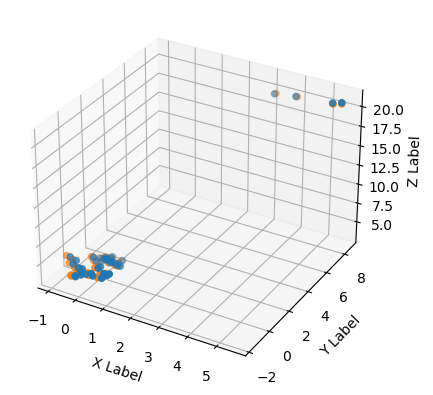

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(structure[:,0], structure[:,1], structure[:,2])
ax.scatter(new_structure[:,0], new_structure[:,1], new_structure[:,2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()